In [1]:
#Installing the necessary packages which need to be updated

#nightly works only in Google Colab with TPU Runtime
try:
  !pip install tf-nightly
except Exception:
  pass
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 553.8 MB 24 kB/s 
     |████████████████████████████████| 439 kB 62.7 MB/s 
     |████████████████████████████████| 5.7 MB 54.4 MB/s 
     |████████████████████████████████| 1.7 MB 84.8 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 3.5 MB/s 
     |████████████████████████████████| 182 kB 70.5 MB/s 
     |

In [2]:
#Importing the files

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plot
import plotly.express as px
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import transformers
import tensorflow as tf
from keras.layers import Dense, Input, Embedding, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
import string
from plotly import graph_objs as go
from transformers import BertTokenizer
from keras.preprocessing.text import Tokenizer
from transformers import TFBertModel
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from keras import layers
import nltk
from nltk.corpus import stopwords
from textblob import Word
from sklearn import svm
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.preprocessing import LabelEncoder
import keras
from keras_preprocessing.sequence import pad_sequences

In [3]:
#Updating the existing nltk libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
#Uploadinig the SMSSpamCollection file to Google Colab
uploaded = files.upload()

Saving SMSSpamCollection to SMSSpamCollection


In [5]:
data = pd.read_csv('SMSSpamCollection', sep ='\t', names=['class', 'message'])

#Explorartory Data Analysis

In [6]:
data.describe()

,class,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
rows = len(data.axes[0])
cols = len(data.axes[1])
print('Total Columns in the Corpus:', cols)
print('Total Entries in the Corpus :', rows)

Total Columns in the Corpus: 2
Total Entries in the Corpus : 5572


In [8]:
data.sample(10)

,class,message
1454,ham,Stupid.its not possible
3512,ham,I'm serious. You are in the money base
169,ham,Great escape. I fancy the bridge but needs her...
675,ham,"I've got &lt;#&gt; , any way I could pick up?"
3180,ham,Does cinema plus drink appeal tomo? * Is a fr ...
1021,ham,Good afternoon on this glorious anniversary da...
126,ham,"Good stuff, will do."
2586,ham,I will be outside office take all from there
1095,ham,Now only i reached home. . . I am very tired n...
2324,ham,Sorry dude. Dont know how i forgot. Even after...


In [9]:
print('Occourences of Ham and Spam')
data['class'].value_counts()

Occourences of Ham and Spam


ham     4825
spam     747
Name: class, dtype: int64

In [10]:
fig = px.pie(data_frame = data, names = 'class', hole = 0.5, title = 'Ham vs Spam', 
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

In [11]:
#Frequently occuring text messages
frequent_messages = data.groupby('message')['class'].agg([len, np.max]).sort_values(by = 'len', ascending = False).head(n = 10)
frequent_messages

,len,amax
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Ok,4,ham
Okie,4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st ""Ur Lovely Friendship""... good morning dear",4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,4,spam


In [12]:
dup = data.duplicated().sum()
print('Number of duplicate values:', dup)

Number of duplicate values: 403


In [13]:
#Removing duplicate entries as they would change the model's fitting parameters
data.drop_duplicates(inplace = True)

In [14]:
print('Checking for null values')
data.isnull().sum()

Checking for null values


class      0
message    0
dtype: int64

In [15]:
#Counting number of characters in each message
data['char'] = data['message'].apply(len)
#Counting number of words in each message
data['word'] = data.apply(lambda row: nltk.word_tokenize(row['message']), axis=1).apply(len)
#Counting number of sentences in each message.
data['sent'] = data.apply(lambda row: nltk.sent_tokenize(row['message']), axis=1).apply(len)

data.describe()

,char,word,sent
count,5169.000000,5169.000000,5169.000000
mean,79.344554,18.591023,1.954924
std,58.437457,13.402840,1.366937
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,119.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


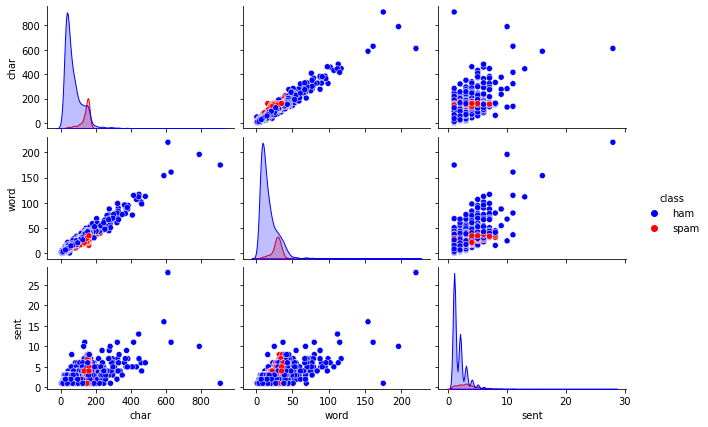

In [16]:
fig = sns.pairplot(data = data, hue = 'class', palette = ['blue', 'red'], height = 2, aspect = 1.5)
plt.show(fig)

In [17]:
#Preparing the data for Word Cloud by removing the stop words and changing text to lower case
spam = data[data['class'] == 'spam']['message']
ham = data[data['class'] == 'ham']['message']
hw = []

sw = []

def extractSpamWords(sm):
    global sw
    words = [word.lower() for word in word_tokenize(sm) if word.lower() not in stopwords.words('english') and word.lower().isalpha()]
    sw = sw + words
    
def extractHamWords(hm):
    global hw
    words = [word.lower() for word in word_tokenize(hm) if word.lower() not in stopwords.words('english') and word.lower().isalpha()]
    hw = hw + words

spam.apply(extractSpamWords)
ham.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4516, dtype: object

##Most common words in Spam Messages

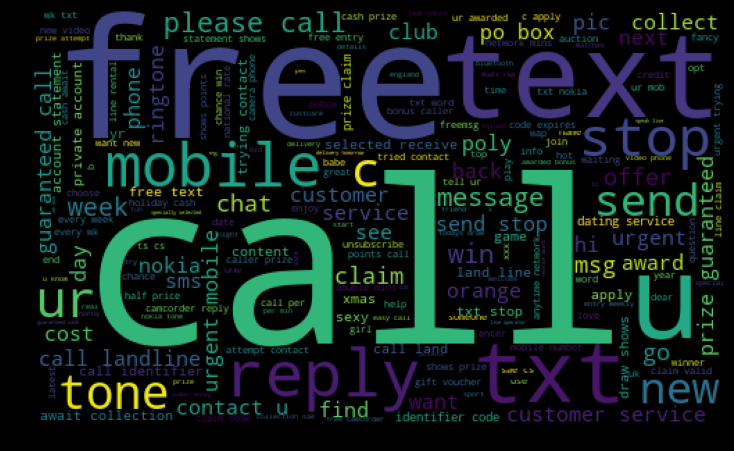

In [18]:
swc = WordCloud(width = 500, height = 300).generate(' '.join(sw))
plt.figure( figsize = (10,8), facecolor = 'k')
plt.imshow(swc)
plt.tight_layout(pad = 0)
plt.show()

##Most common words in Ham Messages

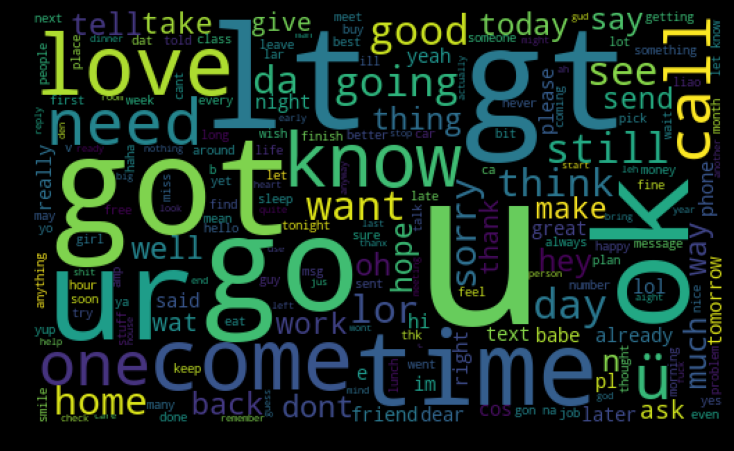

In [19]:
hwc = WordCloud(width = 500, height = 300).generate(' '.join(hw))
plt.figure( figsize = (10,8), facecolor = 'k')
plt.imshow(hwc)
plt.tight_layout(pad = 0)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



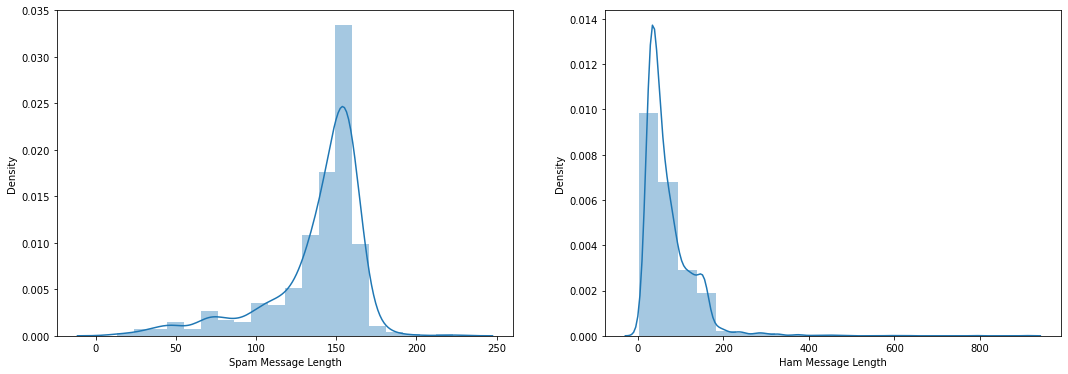

In [20]:
data['mess_len'] = data['message'].apply(len)
data['mess_len'].describe()

f, ax = plt.subplots(1, 2, figsize = (18, 6))

sns.distplot(data[data['class'] == 'spam']['mess_len'], bins = 20, ax = ax[0])
ax[0].set_xlabel('Spam Message Length')

sns.distplot(data[data['class'] == 'ham']['mess_len'], bins = 20, ax = ax[1])
ax[1].set_xlabel('Ham Message Length')

plt.show()

###As we can see, the length of a message which is ham, is clearly lower than that of spam messages.

#DATA CLEANING

In [21]:
#Function to standardize the text by removing all the numbers, urls, punctuations etc
def cleanup(ip):
    ip = str(ip).lower() #Changing the text to lower case
    ip = re.sub('<.*?>+', '', ip) #Removing Punctuations
    ip = re.sub('[%s]' % re.escape(string.punctuation), '', ip) #Removing numbers
    ip = re.sub('https?://\S+|www\.\S+', '', ip) #Removing web URLs
    ip = re.sub('\n', '', ip) #Removing line breaks
    ip = re.sub('\[.*?\]', '', ip)
    ip = re.sub('\w*\d\w*', '', ip)
    return ip

In [22]:
data['message_clean'] = data['message'].apply(cleanup)
data.head()

,class,message,char,word,sent,mess_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,155,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,49,13,1,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,61,nah i dont think he goes to usf he lives aroun...


In [23]:
stop_words = stopwords.words('english')
#Additional stop words that were visible as per the Word Clouds
add_stop = ['u', 'im', 'c']
stop_words = stop_words + add_stop

def remove_sw(ip):
    ip = ' '.join(word for word in ip.split(' ') if word not in stop_words)
    return ip
    
data['message_clean'] = data['message_clean'].apply(remove_sw)
data.head()

,class,message,char,word,sent,mess_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,155,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,13,1,49,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,61,nah dont think goes usf lives around though


Creating 4 dataframes for: Sampled Lemmatized, Unsampled Lemmatized, Sampled & Stemmed, Unsampled & Stemmed.

As we saw earlier, there was a clear imbalance in the corpus but one of the things that we wanted to check is that even after balancing the corpus, along with using stemming and lemmatization on them, do the results differ

In [24]:
SL = data.copy()
UL = data.copy()
SS = data.copy()
US = data.copy()

In [25]:
#Sampling the 2 datasets
h1 = SS[SS['class'] =='ham']
s1 = SS[SS['class']=='spam']
hm = h1.sample(n = len(s1), random_state = 1)
SS = hm.append(s1).reset_index(drop=True)

h2 = SL[SL['class'] =='ham']
s2 = SL[SL['class']=='spam']
hm1 = h2.sample(n = len(s2), random_state = 1)
SL = hm1.append(s2).reset_index(drop=True)

In [26]:
#Creating a stemmer
stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [27]:
#Stemming the US (Unsampled & Stemmed) Dataframe
US['message_clean'] = US['message_clean'].apply(stemm_text)
US.head()

,class,message,char,word,sent,mess_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,29,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,155,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,13,1,49,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,61,nah dont think goe usf live around though


In [28]:
#Stemming the SS (Sampled & Stemmed) Dataframe
SS['message_clean'] = SS['message_clean'].apply(stemm_text)
SS.head()

,class,message,char,word,sent,mess_len,message_clean
0,ham,Am also doing in cbe only. But have to pay.,43,12,2,43,also cbe pay
1,ham,Babe! I fucking love you too !! You know? Fuck...,157,45,8,157,babe fuck love know fuck good hear voic need ...
2,ham,TELL HER I SAID EAT SHIT.,25,7,1,25,tell said eat shit
3,ham,Poor girl can't go one day lmao,31,8,1,31,poor girl cant go one day lmao
4,ham,Same. Wana plan a trip sometme then,35,8,2,35,wana plan trip sometm


In [29]:
#Lemmatizing the Unsampled dataset

UL['message_clean'] = UL['message_clean'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

In [30]:
#Lemmatizing the SL dataset

SL['message_clean'] = SL['message_clean'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

#Target Encoding

In [31]:
le = LabelEncoder()

In [32]:
le.fit(UL['class'])

UL['target_encoded'] = le.transform(UL['class'])
UL.head()

,class,message,char,word,sent,mess_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,111,go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,29,8,2,29,ok lar joking wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,155,free entry wkly comp win fa cup final tkts may...,1
3,ham,U dun say so early hor... U c already then say...,49,13,1,49,dun say early hor already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,61,nah dont think go usf life around though,0


In [33]:
le.fit(US['class'])

US['target_encoded'] = le.transform(US['class'])

In [34]:
le.fit(SS['class'])

SS['target_encoded'] = le.transform(SS['class'])

In [35]:
le.fit(SL['class'])

SL['target_encoded'] = le.transform(SL['class'])

#Model Implementations

##SVM

###Lemmatization

####Unsampled

In [36]:
X = UL['message_clean']
y = UL['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [37]:
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(X_train)
 
tuned_parameters = {'kernel':['linear','rbf'],'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}
 
model = GridSearchCV(svm.SVC(),tuned_parameters)
model.fit(feature, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [39]:
y_predict = tfidf.transform(X_test)
print('Accuracy of the model:',round(model.score(y_predict, y_test),5))

Accuracy of the model: 0.98221


####Sampled

In [40]:
X = SL['message_clean']
y = SL['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [41]:
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(X_train)
 
tuned_parameters = {'kernel':['linear','rbf'],'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}
 
model = GridSearchCV(svm.SVC(),tuned_parameters)
model.fit(feature, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [42]:
y_predict = tfidf.transform(X_test)
print('Accuracy of the model:',round(model.score(y_predict,y_test),5))

Accuracy of the model: 0.92355


###Stemming

####Unsampled

In [43]:
X = US['message_clean']
y = US['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [44]:
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(X_train)
 
tuned_parameters = {'kernel':['linear','rbf'],'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}
 
model = GridSearchCV(svm.SVC(),tuned_parameters)
model.fit(feature, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [45]:
y_predict = tfidf.transform(X_test)
print('Accuracy of the model:',round(model.score(y_predict, y_test),5))

Accuracy of the model: 0.98067


####Sampled

In [46]:
X = SS['message_clean']
y = SS['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [47]:
tfidf = TfidfVectorizer()
feature = tfidf.fit_transform(X_train)
 
tuned_parameters = {'kernel':['linear','rbf'],'gamma':[1e-3,1e-4], 'C':[1,10,100,1000]}
 
model = GridSearchCV(svm.SVC(),tuned_parameters)
model.fit(feature, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']})

In [48]:
y_predict = tfidf.transform(X_test)
print('Accuracy of the model:',round(model.score(y_predict, y_test),5))

Accuracy of the model: 0.92355


##BERT

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Current number of replicas running concurrently: ', strategy.num_replicas_in_sync)

Current number of replicas running concurrently:  1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            max_length = max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])        
    return np.array(input_ids),np.array(attention_masks)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def learning_curve(hist, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for i in range(2):
        ax[i].plot(hist.history[arr[i][0]])
        ax[i].plot(hist.history[arr[i][1]])
        ax[i].legend([arr[i][0], arr[i][1]],fontsize=16)
        ax[i].set_xlabel('A ',fontsize=13)
        ax[i].set_ylabel('B',fontsize=13)
        ax[i].set_title(arr[i][0] + ' X ' + arr[i][1], fontsize=13)

###Lemmatized Dataframes

####Unsampled

In [ ]:
message = UL['message_clean']
target = UL['target_encoded']

train_ip, train_am = bert_encode(message,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
hist = model.fit([train_ip, train_am], target, validation_split = 0.25, epochs = 3, batch_size=10)

Epoch 1/3
388/388 [==============================] - 87s 182ms/step - loss: 0.1694 - accuracy: 0.9445 - val_loss: 0.0500 - val_accuracy: 0.9845
Epoch 2/3
388/388 [==============================] - 66s 171ms/step - loss: 0.0571 - accuracy: 0.9863 - val_loss: 0.0605 - val_accuracy: 0.9791
Epoch 3/3
388/388 [==============================] - 66s 171ms/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0379 - val_accuracy: 0.9884


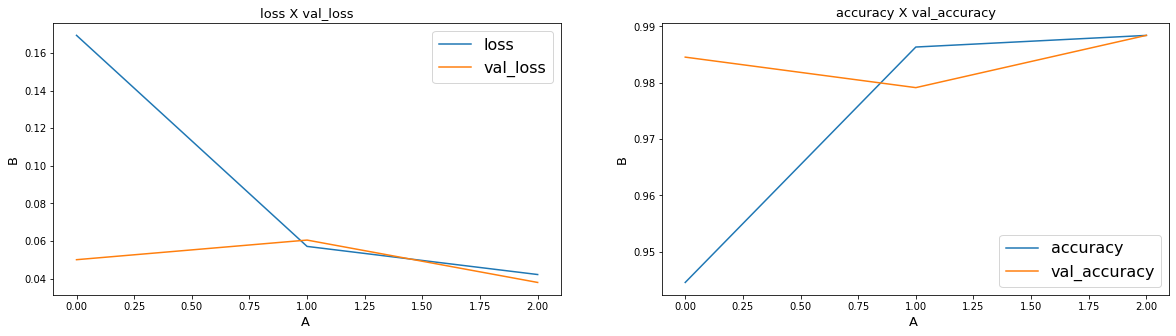

In [ ]:
learning_curve(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

####Sampled

In [ ]:
message = SL['message_clean']
target = SL['target_encoded']

train_ip, train_am = bert_encode(message,60)

In [ ]:
hist = model.fit([train_ip, train_am], target, validation_split = 0.25, epochs = 3, batch_size = 10)

Epoch 1/3
98/98 [==============================] - 17s 171ms/step - loss: 0.0500 - accuracy: 0.9888 - val_loss: 0.2044 - val_accuracy: 0.9511
Epoch 2/3
98/98 [==============================] - 17s 172ms/step - loss: 0.0251 - accuracy: 0.9939 - val_loss: 0.2630 - val_accuracy: 0.9388
Epoch 3/3
98/98 [==============================] - 16s 163ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.1543 - val_accuracy: 0.9602


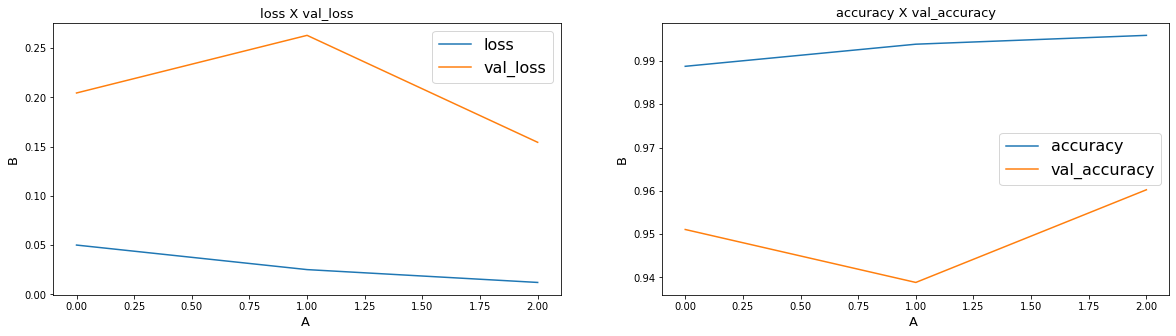

In [ ]:
learning_curve(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

###Stemmed Dataframes

####Unsampled

In [ ]:
message = US['message_clean']
target = US['target_encoded']

train_ip, train_am = bert_encode(message,60)

In [ ]:
hist = model.fit([train_ip, train_am], target, validation_split=0.25, epochs=  3, batch_size = 10)

Epoch 1/3
388/388 [==============================] - 68s 175ms/step - loss: 0.0460 - accuracy: 0.9866 - val_loss: 0.0549 - val_accuracy: 0.9884
Epoch 2/3
388/388 [==============================] - 69s 178ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0685 - val_accuracy: 0.9845
Epoch 3/3
388/388 [==============================] - 66s 171ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0904 - val_accuracy: 0.9853


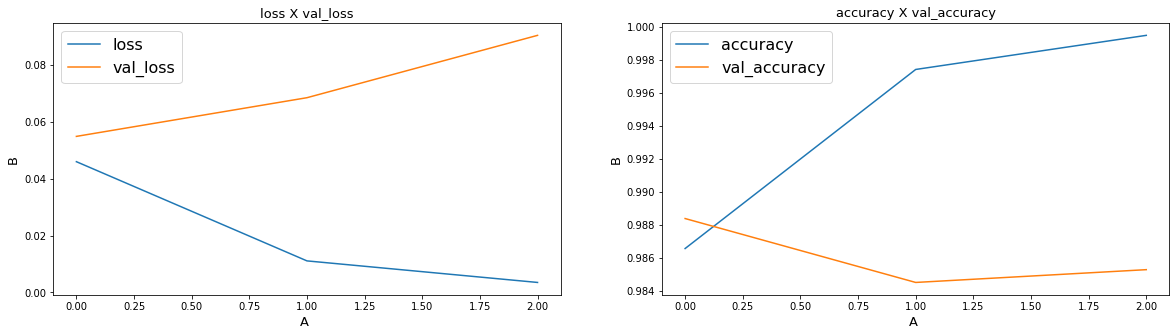

In [ ]:
learning_curve(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

####Sampled

In [ ]:
messages = SS['message_clean']
target = SS['target_encoded']

train_ip, train_am = bert_encode(messages,60)

In [ ]:
hist = model.fit([train_ip, train_am], target, validation_split = 0.25,  epochs = 3, batch_size = 10)

Epoch 1/3
98/98 [==============================] - 17s 171ms/step - loss: 0.0162 - accuracy: 0.9969 - val_loss: 0.2025 - val_accuracy: 0.9633
Epoch 2/3
98/98 [==============================] - 17s 171ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.1152 - val_accuracy: 0.9694
Epoch 3/3
98/98 [==============================] - 16s 163ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1814 - val_accuracy: 0.9694


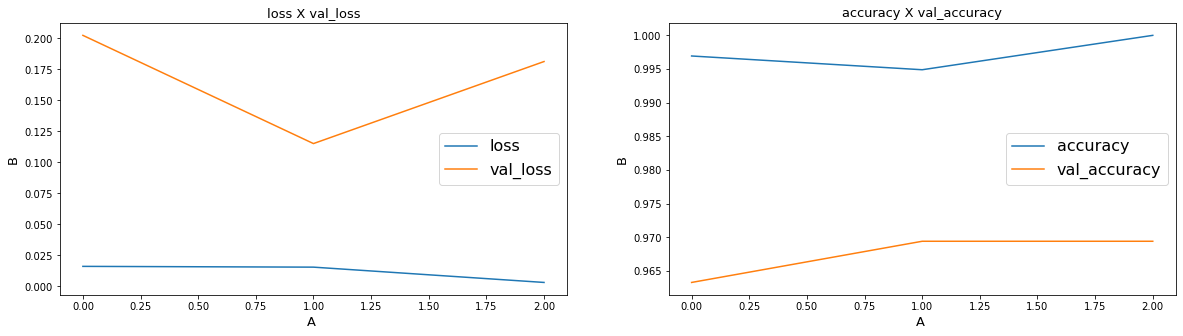

In [ ]:
learning_curve(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

##Neural Networks

###Lemmatization

####Unsampled

In [ ]:
X = UL['message_clean']
y = UL['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  #+1 because of reserved index

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = 100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen = 100)

print(X_train[0, :])

[ 815    8  129 2552  330  816    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           309300    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 342,729
Trainable params: 342,729
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, verbose = True, validation_data = (X_test, y_test), batch_size = 10)

Epoch 1/10
362/362 [==============================] - 4s 9ms/step - loss: 0.2386 - accuracy: 0.9085 - val_loss: 0.0818 - val_accuracy: 0.9774
Epoch 2/10
362/362 [==============================] - 3s 9ms/step - loss: 0.0406 - accuracy: 0.9895 - val_loss: 0.0732 - val_accuracy: 0.9826
Epoch 3/10
362/362 [==============================] - 4s 12ms/step - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.0797 - val_accuracy: 0.9826
Epoch 4/10
362/362 [==============================] - 6s 15ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0911 - val_accuracy: 0.9813
Epoch 5/10
362/362 [==============================] - 6s 16ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0980 - val_accuracy: 0.9819
Epoch 6/10
362/362 [==============================] - 5s 13ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.1225 - val_accuracy: 0.9800
Epoch 7/10
362/362 [==============================] - 6s 15ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1056 - val_accuracy: 0.9807
E

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: ',round(accuracy,4))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: ',round(accuracy,4))

Training Accuracy:  0.9994
Testing Accuracy:  0.9807


####Sampled

In [ ]:
X = SL['message_clean']
y = SL['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  #+1 because of reserved index

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = 100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen= 100)

print(X_train[0, :])

[111  94 124  39 125 142 112  10   1 126  63 127   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           133200    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 166,629
Trainable params: 166,629
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, verbose = True, validation_data = (X_test, y_test), batch_size = 10)

Epoch 1/10
92/92 [==============================] - 2s 13ms/step - loss: 0.5175 - accuracy: 0.7845 - val_loss: 0.2660 - val_accuracy: 0.9107
Epoch 2/10
92/92 [==============================] - 1s 11ms/step - loss: 0.1458 - accuracy: 0.9453 - val_loss: 0.1735 - val_accuracy: 0.9439
Epoch 3/10
92/92 [==============================] - 1s 11ms/step - loss: 0.0420 - accuracy: 0.9912 - val_loss: 0.1848 - val_accuracy: 0.9490
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0206 - accuracy: 0.9956 - val_loss: 0.1712 - val_accuracy: 0.9413
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9978 - val_loss: 0.1873 - val_accuracy: 0.9515
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.1739 - val_accuracy: 0.9515
Epoch 7/10
92/92 [==============================] - 1s 11ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.1829 - val_accuracy: 0.9490
Epoch 8/10
92

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: ',round(accuracy,4))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: ',round(accuracy,4))

Training Accuracy:  0.9989
Testing Accuracy:  0.9515


###Stemming

####Unsampled

In [ ]:
X = US['message_clean']
y = US['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  #+1 because of reserved index

In [ ]:
maxlen = 100

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[808  10 136  22 335 809   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           277900    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 311,329
Trainable params: 311,329
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, verbose = True, validation_data = (X_test, y_test), batch_size = 10)

Epoch 1/10
362/362 [==============================] - 5s 13ms/step - loss: 0.2017 - accuracy: 0.9339 - val_loss: 0.0635 - val_accuracy: 0.9839
Epoch 2/10
362/362 [==============================] - 5s 13ms/step - loss: 0.0309 - accuracy: 0.9928 - val_loss: 0.0616 - val_accuracy: 0.9871
Epoch 3/10
362/362 [==============================] - 6s 16ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0688 - val_accuracy: 0.9839
Epoch 4/10
362/362 [==============================] - 6s 17ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0743 - val_accuracy: 0.9832
Epoch 5/10
362/362 [==============================] - 5s 14ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0852 - val_accuracy: 0.9826
Epoch 6/10
362/362 [==============================] - 4s 12ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0818 - val_accuracy: 0.9832
Epoch 7/10
362/362 [==============================] - 5s 14ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0840 - val_accuracy: 0.9832

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: ',round(accuracy,4))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: ',round(accuracy,4))

Training Accuracy:  0.9994
Testing Accuracy:  0.9826


####Sampled

In [ ]:
X = SS['message_clean']
y = SS['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  #+1 because of reserved index

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen= 100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen= 100)

print(X_train[0, :])

[120  98 134  43 135 154 121  10   1 136  72 137   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           123800    
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 157,229
Trainable params: 157,229
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs = 10, verbose = True, validation_data = (X_test, y_test), batch_size = 10)

Epoch 1/10
92/92 [==============================] - 2s 13ms/step - loss: 0.5155 - accuracy: 0.7877 - val_loss: 0.2503 - val_accuracy: 0.9184
Epoch 2/10
92/92 [==============================] - 1s 14ms/step - loss: 0.1342 - accuracy: 0.9573 - val_loss: 0.1852 - val_accuracy: 0.9337
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 0.1715 - val_accuracy: 0.9490
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0209 - accuracy: 0.9956 - val_loss: 0.1761 - val_accuracy: 0.9490
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.1749 - val_accuracy: 0.9541
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.1947 - val_accuracy: 0.9464
Epoch 7/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.1675 - val_accuracy: 0.9617
Epoch 8/10
92

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: ',round(accuracy,4))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: ',round(accuracy,4))

Training Accuracy:  0.9989
Testing Accuracy:  0.9643


##LSTM

In [ ]:
lb_enc = LabelEncoder()

###Lemmatization

####Unsampled

In [ ]:
X = UL['message_clean']
y = lb_enc.fit_transform(UL['class'])

In [ ]:
tokenizer = Tokenizer()
#Fitting the model on the cleaned messages
tokenizer.fit_on_texts(X)

#Creating a numeric sequence
text_to_sequence = tokenizer.texts_to_sequences(X)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
#Looking for the largest sequence's length
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen = max_length_sequence,  padding = 'pre') 
padded_sms_sequence

array([[   0,    0,    0, ...,   12, 3173,   66],
       [   0,    0,    0, ..., 1098,  309, 1431],
       [   0,    0,    0, ...,   35, 3175,  324],
       ...,
       [   0,    0,    0, ..., 1408, 7710, 3169],
       [   0,    0,    0, ...,  741,  127,   10],
       [   0,    0,    0, ..., 1950,  412,  180]], dtype=int32)

In [ ]:
TOT_SIZE = len(tokenizer.word_index)+1
#Creating the model
def create_model():
      lstm_obj = Sequential()
      lstm_obj.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_obj.add(LSTM(100))
      lstm_obj.add(Dropout(0.4))
      lstm_obj.add(Dense(20, activation="relu"))
      lstm_obj.add(Dropout(0.3))
      lstm_obj.add(Dense(1, activation = "sigmoid"))
      return lstm_obj
lstm_obj = create_model()
lstm_obj.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
lstm_obj.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 80, 32)            246784    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 302,025
Trainable params: 302,025
Non-tr

In [ ]:
lstm_obj.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.25, batch_size=16)

Epoch 1/5
259/259 [==============================] - 13s 43ms/step - loss: 0.2264 - accuracy: 0.9301 - val_loss: 0.0814 - val_accuracy: 0.9729
Epoch 2/5
259/259 [==============================] - 11s 41ms/step - loss: 0.0483 - accuracy: 0.9884 - val_loss: 0.0698 - val_accuracy: 0.9749
Epoch 3/5
259/259 [==============================] - 11s 41ms/step - loss: 0.0227 - accuracy: 0.9947 - val_loss: 0.0632 - val_accuracy: 0.9826
Epoch 4/5
259/259 [==============================] - 12s 45ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.0717 - val_accuracy: 0.9865
Epoch 5/5
259/259 [==============================] - 11s 41ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.0769 - val_accuracy: 0.9874


Training Accuracy: 0.999, Validation Accuracy: 0.9874

####Sampled

In [ ]:
X = SL['message_clean']
y = lb_enc.fit_transform(SL['target_encoded'])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = 'pre') 

array([[   0,    0,    0, ...,   58,  919, 1375],
       [   0,    0,    0, ...,    0,    0, 1376],
       [   0,    0,    0, ...,  360,    9,  308],
       ...,
       [   0,    0,    0, ...,  916,  653,  549],
       [   0,    0,    0, ...,  109,  413,  867],
       [   0,    0,    0, ...,   42,  131,  409]], dtype=int32)

In [ ]:
TOT_SIZE = len(tokenizer.word_index) + 1
def create_model():
      lstm_obj = Sequential()
      lstm_obj.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_obj.add(LSTM(100))
      lstm_obj.add(Dropout(0.4))
      lstm_obj.add(Dense(20, activation='relu'))
      lstm_obj.add(Dropout(0.3))
      lstm_obj.add(Dense(1, activation = 'sigmoid'))
      return lstm_obj
lstm_obj = create_model()
lstm_obj.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
lstm_obj.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 71, 32)            106560    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 20)                2020      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-tr

In [ ]:
lstm_obj.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.25, batch_size=16)

Epoch 1/5
66/66 [==============================] - 6s 43ms/step - loss: 0.5557 - accuracy: 0.7126 - val_loss: 0.5267 - val_accuracy: 0.8359
Epoch 2/5
66/66 [==============================] - 2s 36ms/step - loss: 0.2157 - accuracy: 0.9320 - val_loss: 0.3693 - val_accuracy: 0.8435
Epoch 3/5
66/66 [==============================] - 3s 42ms/step - loss: 0.0698 - accuracy: 0.9808 - val_loss: 0.1824 - val_accuracy: 0.9198
Epoch 4/5
66/66 [==============================] - 5s 72ms/step - loss: 0.0304 - accuracy: 0.9923 - val_loss: 0.4253 - val_accuracy: 0.8817
Epoch 5/5
66/66 [==============================] - 5s 71ms/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.2872 - val_accuracy: 0.9351


Training Accuracy: 0.9933, Validation Accuracy: 0.9351

###Stemming

####Unsampled

In [ ]:
X = US['message_clean']
y = lb_enc.fit_transform(US['target_encoded'])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen = max_length_sequence, 
                                    padding = 'pre') 

array([[   0,    0,    0, ...,   14, 2928,   66],
       [   0,    0,    0, ...,  548,  319, 1388],
       [   0,    0,    0, ...,   37, 2930,  310],
       ...,
       [   0,    0,    0, ..., 1367, 6891, 1234],
       [   0,    0,    0, ...,  738,  138,   12],
       [   0,    0,    0, ..., 1850,  410,  185]], dtype=int32)

In [ ]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
      lstm_obj = Sequential()
      lstm_obj.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_obj.add(LSTM(100))
      lstm_obj.add(Dropout(0.4))
      lstm_obj.add(Dense(20, activation='relu'))
      lstm_obj.add(Dropout(0.3))
      lstm_obj.add(Dense(1, activation = 'sigmoid'))
      return lstm_obj
lstm_obj = create_model()
lstm_obj.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
lstm_obj.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 32)            220544    
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 20)                2020      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 21        
                                                                 
Total params: 275,785
Trainable params: 275,785
Non-tr

In [ ]:
lstm_obj.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.25, batch_size=16)

Epoch 1/5
259/259 [==============================] - 15s 47ms/step - loss: 0.1996 - accuracy: 0.9391 - val_loss: 0.0637 - val_accuracy: 0.9807
Epoch 2/5
259/259 [==============================] - 17s 67ms/step - loss: 0.0453 - accuracy: 0.9894 - val_loss: 0.0563 - val_accuracy: 0.9826
Epoch 3/5
259/259 [==============================] - 15s 58ms/step - loss: 0.0152 - accuracy: 0.9969 - val_loss: 0.0701 - val_accuracy: 0.9768
Epoch 4/5
259/259 [==============================] - 11s 44ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0747 - val_accuracy: 0.9797
Epoch 5/5
259/259 [==============================] - 12s 46ms/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.0878 - val_accuracy: 0.9807


Training Accuracy: 0.9985, Validation Accuracy: 0.9807

####Sampled

In [ ]:
X = SS['message_clean']
y = lb_enc.fit_transform(SS['target_encoded'])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X)

In [ ]:
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = 'pre') 

array([[   0,    0,    0, ...,   52,  889, 1307],
       [   0,    0,    0, ...,    0,    0, 1308],
       [   0,    0,    0, ...,  358,    7,  287],
       ...,
       [   0,    0,    0, ...,  885,  409,  363],
       [   0,    0,    0, ...,  118,  417,  843],
       [   0,    0,    0, ...,   45,  136,  415]], dtype=int32)

In [ ]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
      lstm_obj = Sequential()
      lstm_obj.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_obj.add(LSTM(100))
      lstm_obj.add(Dropout(0.4))
      lstm_obj.add(Dense(20, activation='relu'))
      lstm_obj.add(Dropout(0.3))
      lstm_obj.add(Dense(1, activation = 'sigmoid'))
      return lstm_obj
lstm_obj = create_model()
lstm_obj.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
lstm_obj.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 71, 32)            98080     
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 20)                2020      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 153,321
Trainable params: 153,321
Non-tr

In [ ]:
lstm_obj.fit(padded_sms_sequence, y, epochs = 5, validation_split = 0.25, batch_size = 16)

Epoch 1/5
66/66 [==============================] - 7s 60ms/step - loss: 0.5369 - accuracy: 0.7222 - val_loss: 0.8496 - val_accuracy: 0.6756
Epoch 2/5
66/66 [==============================] - 3s 43ms/step - loss: 0.1729 - accuracy: 0.9416 - val_loss: 0.1329 - val_accuracy: 0.9580
Epoch 3/5
66/66 [==============================] - 3s 53ms/step - loss: 0.0731 - accuracy: 0.9866 - val_loss: 0.2461 - val_accuracy: 0.9275
Epoch 4/5
66/66 [==============================] - 3s 49ms/step - loss: 0.4722 - accuracy: 0.9262 - val_loss: 0.6673 - val_accuracy: 0.5878
Epoch 5/5
66/66 [==============================] - 4s 58ms/step - loss: 0.4180 - accuracy: 0.8429 - val_loss: 1.0060 - val_accuracy: 0.8015


Training Accuracy: 0.8429, Validation Accuracy: 0.8015